# Import all libraries

In [17]:
import numpy as np
import torch
import networkx as nx
from tqdm import tqdm

from Architecture.Layers import ChaoticRNN
import matplotlib.pyplot as plt

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    !nvidia-smi
    print(torch.cuda.get_device_name(0))

else:
    print("No GPU :(")

Mon May  1 03:14:39 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti      Off| 00000000:01:00.0  On |                  N/A |
| N/A   45C    P5                9W /  N/A|    863MiB /  4096MiB |     29%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
device = torch.device('cpu')

In [20]:
from sklearn.metrics import f1_score, accuracy_score

def validate(model, valid_batch_loader):
    # Create empty lists to store predictions and labels
    predictions = []
    labels = []

    # Iterate over validation set
    for i, (features, ans) in tqdm(enumerate(valid_batch_loader), total=len(valid_batch_loader), desc='Validation', leave=True, colour='green'):

        # Get one-hot encoded label
        ans = torch.eye(output_size)[ans]

        # Forward pass
        Y_pred, time = model.forward(features.view(-1, input_size), return_work_time=True)

        # Get prediction
        prediction = torch.argmax(Y_pred, dim=0).item()

        # Append to lists
        predictions.append(prediction)
        labels.append(torch.argmax(ans.view(-1, output_size), dim=1).item())

    # Calculate metrics
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return f1, acc

# Create a dataset
Here I would create a bell shaped function

In [21]:
# Bell shaped function
def bell_shaped(x, a=1, b=0, c=1):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Create a dataset
discretization = 20
t = np.linspace(0, 20, discretization)
y = bell_shaped(t, a=1, b=10, c=3)


0.0038659201394728076


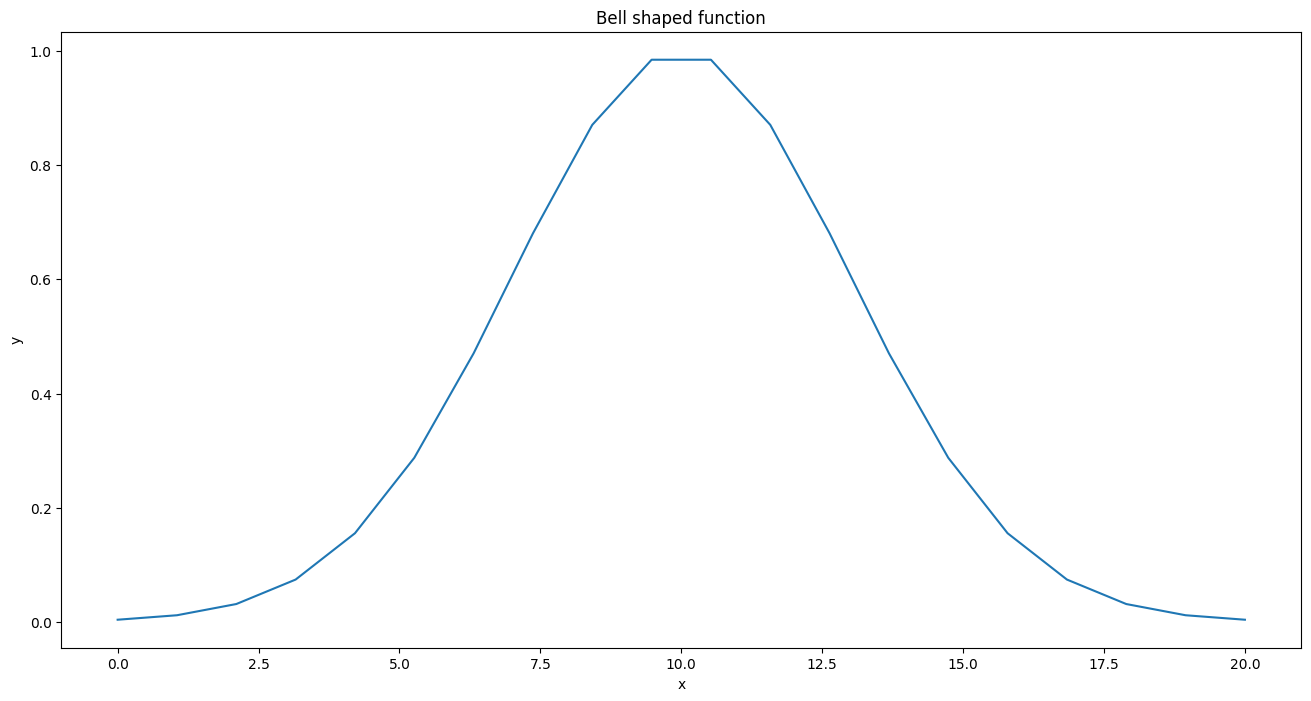

In [22]:
# Plot
plt.figure(figsize=(16, 8))
print(y[0])
plt.plot(t, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bell shaped function')
plt.show()

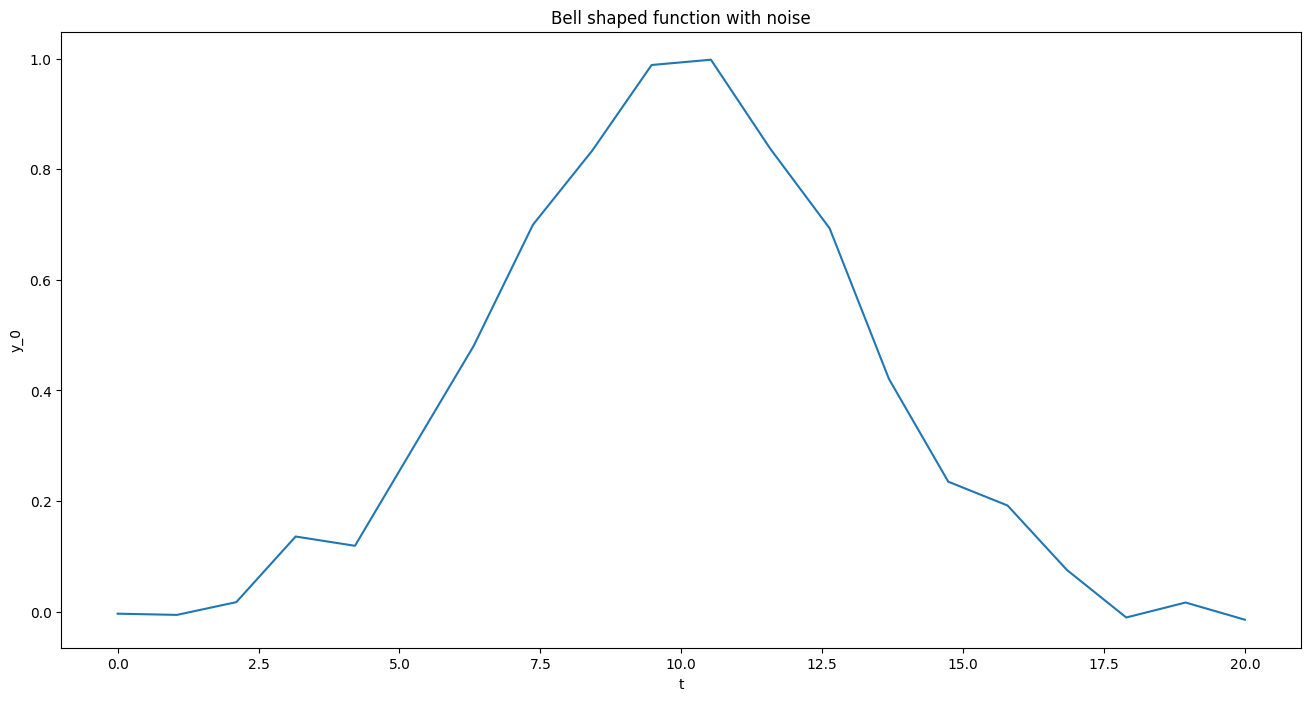

In [23]:
# Add noise to 'y'
noise_scale = 0.03
num_individuals = 200
noise = np.random.normal(0, noise_scale, size=(num_individuals, discretization))
x = np.tile(y, (num_individuals, 1))
x += noise

# Stack y into a tensor
y = np.tile(y, (num_individuals, 1))

# Plot
plt.figure(figsize=(16, 8))
plt.plot(t, x[0])
plt.xlabel('t')
plt.ylabel('y_0')
plt.title('Bell shaped function with noise')
plt.show()

In [24]:
# Create a dataset
dataset = torch.utils.data.TensorDataset(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))

# Get a random individual from dataset
rand_individ = np.random.randint(0, num_individuals)
print(f'x: {dataset[rand_individ][0].shape}')
print(f'y: {dataset[rand_individ][1].shape}')

x: torch.Size([20])
y: torch.Size([20])


# Configure NN Model and hyper-parameters

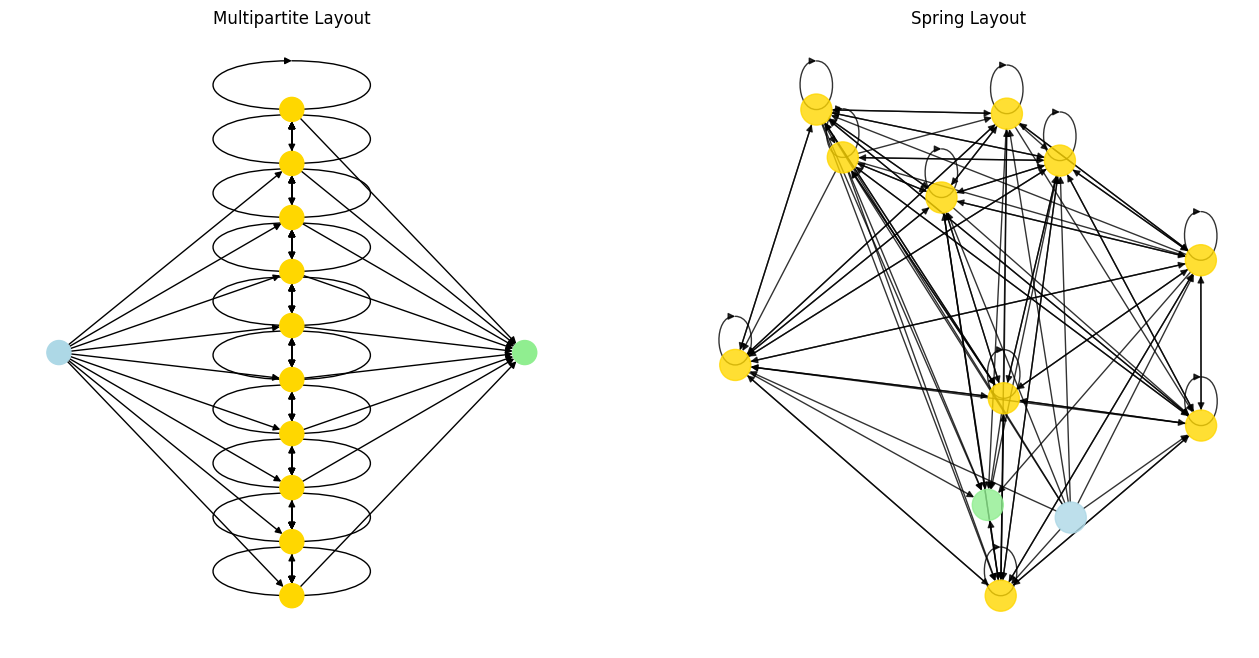

nodes: 12
 edges: 105


In [25]:
input_size = 1
hidden_size = 10
output_size = 1

model = ChaoticRNN(input_size, output_size, hidden_size, connect_percentage=0.9).to(device)

model.visualize()
print(f'nodes: {len(model.graph.nodes)}\n edges: {len(model.graph.edges)}')

In [26]:
# f1, acc = validate(model, valid_batch_loader)
# print(f'Metrics without training:\nF1: {f1}\nACC: {acc}')

# Train loop

In [27]:
# Configure hyper-parameters
epochs = 1
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = []
loss_accomulator = []

In [28]:
for epoch in range(0, epochs):
    for i, (features, ans) in enumerate(tqdm(dataset, desc=f"Epoch {epoch + 1}", leave=False, colour='green')):

        # Forward over all points
        model.reset_neurons_memory()
        for X, Y in zip(features[:-1], ans[1:]):
            Y_pred = model.forward(X.view(-1, input_size)).to(device)

            # Calculate loss
            loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

            # Backward pass
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()

            # Append loss to list
            loss_accomulator.append(loss.item())

        history.append(np.mean(loss_accomulator))
        loss_accomulator = []

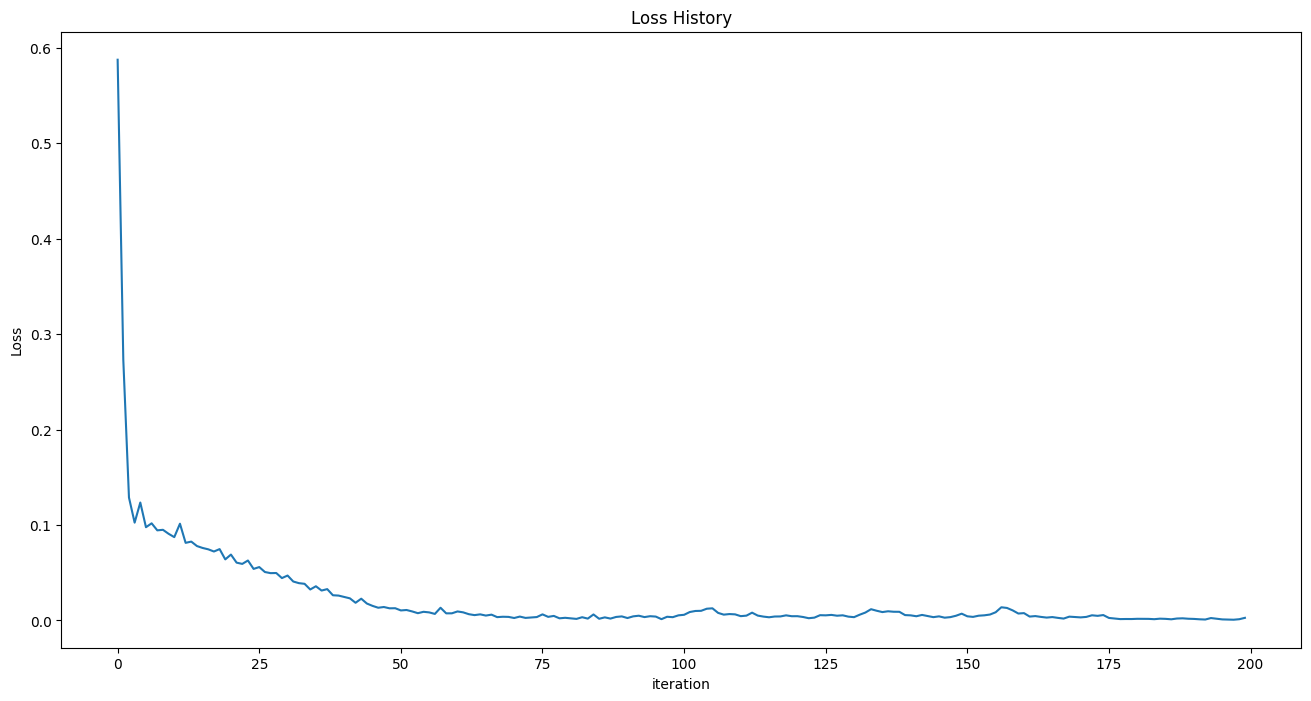

In [29]:
# Plot loss history
plt.figure(figsize=(16, 8))
plt.plot(history)
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()

# Draw function by trained model only

In [30]:
start_point_num = 5
predicitons = [[] for _ in range(start_point_num)]

# Get start points as a linear space
start_points = np.linspace(-0.1, 0.2, start_point_num)

with torch.no_grad():
    for i, start_point in enumerate(start_points):
        # Reset neurons memory
        model.reset_neurons_memory()

        # Create a start point
        x = torch.tensor([start_point], dtype=torch.float32)

        # Forward over all points
        for _ in range(0, discretization):
            y_pred = model.forward(x.view(-1, input_size)).to(device)

            # Append to list
            predicitons[i].append(y_pred.item())

            x = y_pred
    model.reset_neurons_memory()

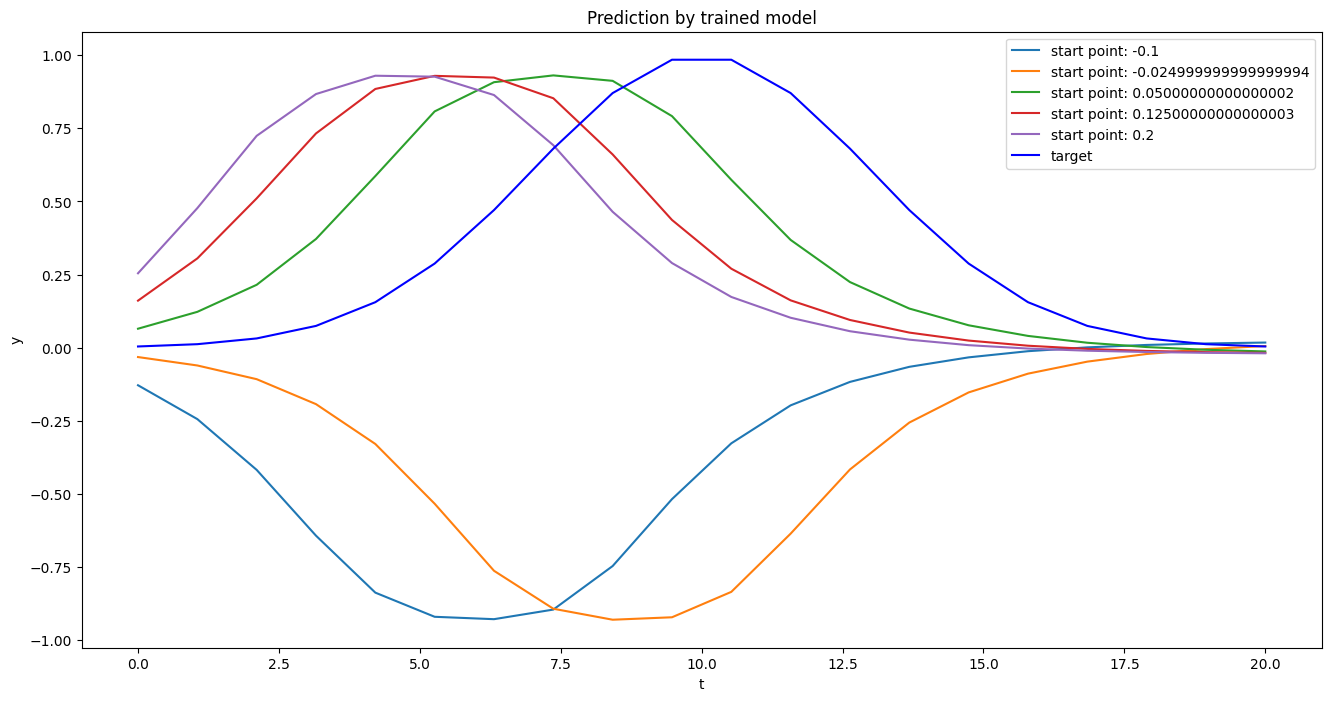

In [31]:
plt.figure(figsize=(16, 8))
for i, prediction in enumerate(predicitons):
    plt.plot(t, prediction, label=f'start point: {start_points[i]}')
plt.plot(t, y[0], label='target', color='blue')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Prediction by trained model')
plt.legend()
plt.show()

# Validate trained model

In [32]:
f1, acc = validate(model, valid_batch_loader)
print(f'Metrics without training:\nF1: {f1}\nACC: {acc}')

NameError: name 'valid_batch_loader' is not defined

# Visualisation test

In [ ]:
rand_individ = np.random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]


with torch.no_grad():
    pred = model.forward(img.view(-1, input_size)).to(device)

plt.imshow(img, cmap='Greys')
plt.xlabel(f"PREDICTION: {pred}, ANSWER {ans}")
pass